In [1]:
# read each job post
# tokenize sentences
# remove non-ascii characters and punctuations
# tokenize words
# form bi-grams and tri-grams

import logging
import re
import os

# text pre-processing
import nltk
from nltk.tokenize import sent_tokenize
from string import punctuation, maketrans, translate

# stopwords
import stop_words

# gensim corpus and models
import gensim
from gensim import corpora, models, similarities
from gensim.models import Phrases

In [2]:
DATA_DIR = os.path.join("/home", "rt", "wrk", "jobs", "data")
MODEL_DIR = os.path.join("/home", "rt", "wrk", "jobs", "models")

In [126]:

class JobCorpus(object):
    def __init__(self, fname):
        self.fname = fname

        # blackist words to be removed from text
        # combines stopwords from nltk, gensim and stop_words package
        self.en_stopwords = set(
            stop_words.get_stop_words('en') +
            nltk.corpus.stopwords.words("english") +
            list(gensim.parsing.preprocessing.STOPWORDS)
        )

        # keep -, +, # in words
        self.punctuation = re.sub("[-+#.]", " ", punctuation)

        # make translation dictionary converting punctuations to white spaces
        self.translate_dict = maketrans(punctuation, ' '*len(punctuation))

        # replace patterns
        self.invalid_char = re.compile(r'[0-9]|\\~|\`|\@|\$|\%|\^|\& \
                |\*|\(|\)|\_|\=|\[|\]|\\|\<|\<|\>|\?|\/|\;|\\.')
        self.url_pattern = re.compile(r'(' +
              # Scheme (HTTP, HTTPS, FTP and SFTP):
              r'(?:(https?|s?ftp):\/\/)?' +
              # www:
              r'(?:www\.)?' + 
              r'(' +
              # Host and domain (including ccSLD):
              r'(?:(?:[A-Z0-9][A-Z0-9-]{0,61}[A-Z0-9]\.)+)' +
              # TLD:
              r'([A-Z]{2,6})' +
              # IP Address:
              r'|(?:\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3})' +
              r')' +
              # Port:
              r'(?::(\d{1,5}))?' +
              # Query path:
              r'(?:(\/\S+)*)' +
              r')', re.IGNORECASE)

        # generator of documents; one element = list of words
        documents = (self.sentence_stream())

        # best bigrams and trigrams
        logging.warning("collecting ngrams")
        self.ngrams = self.best_ngrams(list(documents))
        logging.warning("completed collecting ngrams")

        logging.warning("building dictionary")
        self.dictionary = gensim.corpora.Dictionary(self.tokenize())
        #self.dictionary.compactify()
        self.dictionary.save(os.path.join(MODEL_DIR, "train.dict"))
        self.dictionary.save_as_text(os.path.join(MODEL_DIR, "train.dict.txt"))
        logging.warning(self.dictionary)
        logging.warning("completed building dictionary")
                
    def best_ngrams(self, sentences, threshold=10, min_count=100):
        """
        Extract most salient collocations (bigrams and trigrams) from a stream
        of words. Ignore collocations with frequency lower than `min_count`.

        threshold represents a threshold for forming the phrases (higher means
        fewer phrases). A phrase of words a and b is accepted if
        (cnt(a, b) - min_count) * N / (cnt(a) * cnt(b)) > threshold,
        where N is the total vocabulary size.
        """
        
        bigrams = Phrases(list(sentences),
                          threshold=threshold,
                          min_count=min_count)
        trigrams = Phrases(bigrams[list(sentences)],
                           threshold=threshold,
                           min_count=min_count)

        return trigrams

    def cleanse_text(self, text):
        clean_text = text

        # remove urls from text
        clean_text = self.url_pattern.sub('', clean_text)
        
        # remove punctuations and other characters
        clean_text = translate(
            self.invalid_char.sub(' ', clean_text),
            self.translate_dict)

        return clean_text

    def split_words(self, document):
        """
        Break text into sentences and each sentence into a list of single words
        Ignore any token that falls into the stopwords set.
        """
        # use sentence tokenizer sent_tokenize from nltk package
        sentences = sent_tokenize(document.lower().decode('unicode_escape').encode('ascii', 'ignore'))
        
        for sentence in sentences:
            words = [word
                   for word in gensim.utils.tokenize(
                    self.cleanse_text(sentence)
                   )
                   if word not in self.en_stopwords]
            yield words

    def tokenize(self):
        """
        Break text (string) into a list of unicode tokens.
        The resulting tokens can be longer phrases (collocations) too,
        e.g. `new_york`, `real_estate` etc.
        """
        for document in open(self.fname):
            post = []
            for sentences in self.split_words(document):
                post.extend(self.ngrams[list(sentences)])
            yield post

    def sentence_stream(self):
        for document in open(self.fname):
            post = []
            for sentences in self.split_words(document):
                post.extend(list(sentences))
            yield post
            
    def __iter__(self):
        for sentence in self.tokenize():
            yield self.dictionary.doc2bow(sentence)


In [17]:
jobs_corpus = JobCorpus(os.path.join(DATA_DIR, "train.txt"))

In [18]:
corpora.MmCorpus.serialize(os.path.join(MODEL_DIR, "train_jobs.mm"), jobs_corpus)

In [19]:
corpus = corpora.MmCorpus(os.path.join(MODEL_DIR, "train_jobs.mm"))
print corpus

MmCorpus(10000 documents, 44061 features, 1984177 non-zero entries)


---

In [47]:
MAX_LSI_TOPICS = 100

In [48]:
%%time
dictionary = corpora.Dictionary.load(os.path.join(MODEL_DIR, "train.dict"))
corpus = corpora.MmCorpus(os.path.join(MODEL_DIR, "train_jobs.mm"))

tfidf = models.TfidfModel(corpus, normalize=True)
corpus_tfidf = tfidf[corpus]

# reduce the vector space by projecting  to 10 dimensions
lsi = gensim.models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics = MAX_LSI_TOPICS)

CPU times: user 34.3 s, sys: 4.85 s, total: 39.1 s
Wall time: 40.4 s


In [50]:
# write coordinates to file
fcoords = open(os.path.join(MODEL_DIR, "train_jobs_lsi_coords.csv"), 'wb')
for vector in lsi[corpus]:
    if len(vector) != MAX_LSI_TOPICS:
        continue
    v = '\t'.join([ "{:6.6f}".format(x[1]) for x in vector ])
    fcoords.write(v + '\n')
fcoords.close()

---

In [68]:
# data processing
import numpy as np
import pandas as pd

# learning algorithms
from sklearn.cluster import KMeans, MiniBatchKMeans

# plots
import matplotlib.pyplot as plt
from wordcloud import WordCloud

%matplotlib inline

In [52]:
MAX_K = 300

In [61]:
X = np.loadtxt(os.path.join(MODEL_DIR, "train_jobs_lsi_coords.csv"), delimiter="\t")
init = 1
ks = range(init, MAX_K + 1)

inertias = np.zeros(MAX_K+1-init)
diff = np.zeros(MAX_K+1-init)
diff2 = np.zeros(MAX_K+1-init)
diff3 = np.zeros(MAX_K+1-init)

In [62]:
for k in ks:
    #kmeans = KMeans(k).fit(X)
    kmeans = MiniBatchKMeans(n_clusters=k, init='k-means++', n_init=1, init_size=1000, batch_size=1000).fit(X)
    inertias[k - init - 1] = kmeans.inertia_
    # first difference    
    if k > 1:
        diff[k - init - 1] = inertias[k - init - 1] - inertias[k - init - 2]
    # second difference
    if k > 2:
        diff2[k - init - 1] = diff[k - init - 1] - diff[k - init - 2]
    # third difference
    if k > 3:
        diff3[k - init - 1] = diff2[k - init - 1] - diff2[k - init - 2]

elbow = np.argmin(diff3[3:]) + 3
print elbow

151


In [57]:
print len(inertias), len(ks)

301 301


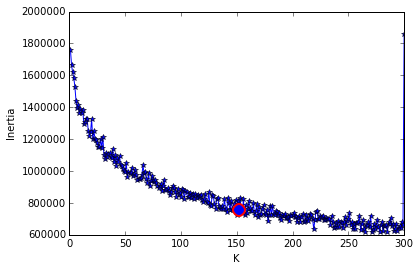

In [63]:
plt.plot(ks, inertias, "b*-")
plt.plot(ks[elbow], inertias[elbow], marker='o', markersize=12,
         markeredgewidth=2, markeredgecolor='r', markerfacecolor=None)
plt.ylabel("Inertia")
plt.xlabel("K")
plt.show()

---

In [64]:
%%time
dictionary = corpora.Dictionary.load(os.path.join(MODEL_DIR, "train.dict"))
corpus = corpora.MmCorpus(os.path.join(MODEL_DIR, "train_jobs.mm"))

# Project to LDA space
NUM_TOPICS = 150
lda = gensim.models.LdaModel(corpus, id2word=dictionary, num_topics=NUM_TOPICS, 
                             chunksize=2000, 
                             passes=20, 
                             alpha='auto',
                             eval_every=10,
                             minimum_probability=0.01
                            )

CPU times: user 45min 9s, sys: 1min 8s, total: 46min 17s
Wall time: 46min 29s


In [65]:
lda.save(os.path.join(MODEL_DIR, "train_model.lda"))

In [66]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda, corpus, dictionary)

/usr/local/lib/python2.7/dist-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:102: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.00516356082502 and the largest is 2.43232738614.
  RuntimeWarning


PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
20     6.934962        1       1 -0.235701  0.133466
74     3.975843        1       2 -0.140762  0.158604
79     3.296740        1       3 -0.215013 -0.011162
118    3.083544        1       4 -0.221878 -0.045682
146    2.904698        1       5 -0.214077 -0.131403
49     2.616590        1       6 -0.166079 -0.024823
114    2.590277        1       7 -0.225615  0.152555
60     2.282506        1       8 -0.146752 -0.038812
135    2.260517        1       9 -0.166109  0.228074
70     2.008460        1      10 -0.168714 -0.001637
69     1.796903        1      11 -0.196257  0.113511
54     1.782445        1      12 -0.129837  0.187924
129    1.780610        1      13 -0.122678 -0.056346
102    1.728907        1      14 -0.180288  0.208806
148    1.642052        1      15 -0.148133 -0.136451
117    1.585211        1      16 -0.172912 -0.079267
138    1.561341        1      17 -0.153768 -0.113739
40     1.511719        1      18 -0.058578  0.001693
27     1.463136        1      19 -0.168485  0.007516
115    1.429191        1      20 -0.148430 -0.020626
8      1.416309        1      21 -0.198340 -0.031358
106    1.413086        1      22 -0.163670 -0.133183
71     1.383252        1      23 -0.133990 -0.172406
15     1.359799        1      24 -0.137582  0.069828
6      1.326058        1      25 -0.081771 -0.010047
124    1.293539        1      26 -0.161644  0.097589
126    1.284541        1      27 -0.138639  0.065594
137    1.136753        1      28 -0.105957  0.051263
12     1.089771        1      29 -0.146099 -0.130370
149    1.000283        1      30 -0.131484 -0.095749
...         ...      ...     ...       ...       ...
72     0.135439        1     121  0.056083 -0.045059
3      0.135218        1     122  0.164426 -0.012665
144    0.131538        1     123  0.107740  0.055003
105    0.123749        1     124  0.177809 -0.005765
67     0.121309        1     125  0.175767  0.005161
93     0.119150        1     126  0.168669  0.028947
97     0.117886        1     127  0.072477 -0.043955
53     0.116356        1     128  0.147486  0.014006
18     0.106978        1     129  0.184195 -0.009352
76     0.105583        1     130  0.129026 -0.036133
98     0.101283        1     131  0.150860  0.006941
29     0.099997        1     132  0.132751  0.026366
13     0.089915        1     133  0.199732  0.001890
46     0.089226        1     134  0.094556  0.062629
109    0.088755        1     135  0.198538  0.013238
48     0.086389        1     136  0.224033  0.002297
14     0.085342        1     137  0.184640  0.013784
37     0.083528        1     138  0.146468  0.015975
116    0.083273        1     139  0.215013  0.003266
141    0.081783        1     140  0.197981 -0.003438
66     0.079220        1     141  0.202564  0.002000
80     0.065242        1     142  0.205967  0.012790
34     0.061209        1     143  0.223180  0.000285
65     0.056968        1     144  0.232933 -0.003551
122    0.055683        1     145  0.231607 -0.004728
19     0.054716        1     146  0.233558 -0.003647
0      0.054484        1     147  0.235957 -0.008699
25     0.048184        1     148  0.198172 -0.012842
81     0.038479        1     149  0.246649 -0.000309
142    0.036726        1     150  0.249017 -0.004889

[150 rows x 5 columns], topic_info=       Category          Freq          Term         Total  loglift  logprob
term                                                                       
11437   Default  18138.000000          data  18138.000000  30.0000  30.0000
10317   Default  16553.000000       ability  16553.000000  29.0000  29.0000
1384    Default  33727.000000    experience  33727.000000  28.0000  28.0000
14665   Default   7354.000000         sales   7354.000000  27.0000  27.0000
1529    Default   4712.000000      research   4712.000000  26.0000  26.0000
12658   Default   7403.000000      customer   7403.000000  25.

In [7]:
lda = gensim.models.ldamodel.LdaModel.load(os.path.join(MODEL_DIR, "train_model.lda"))

In [76]:
ftopics = open(os.path.join(MODEL_DIR, "train_jobs_topics.txt"), 'wb')
for t in lda.print_topics(NUM_TOPICS, 50):
    ftopics.write(str(t[0]) + ':' + t[1] + '\n')
ftopics.close()

In [67]:
fjobtopics = open(os.path.join(MODEL_DIR, "train_jobs_topics.csv"), 'wb')
for doc_id in range(len(corpus)):
    docbow = corpus[doc_id]
    doc_topics = lda.get_document_topics(docbow)
    for topic_id, topic_prob in doc_topics:
        fjobtopics.write("%d\t%d\t%.3f\n" % (doc_id, topic_id, topic_prob))
fjobtopics.close()

In [70]:
topic_df = pd.read_csv(os.path.join(MODEL_DIR, "train_jobs_topics.csv"), sep="\t", 
                   names=["doc_id", "topic_id", "topic_prob"], 
                   skiprows=0)

In [73]:
topic_idx = topic_df.groupby(['doc_id'])['topic_prob'].transform(max) == topic_df['topic_prob']
top_topics = topic_df[topic_idx]
top_topics.groupby(['topic_id'])['topic_id'].agg(['count']).sort_values(by = ['count'], ascending=False)

,count
topic_id,
20,1033
49,543
146,513
135,503
74,368
114,365
79,307
138,293
70,285


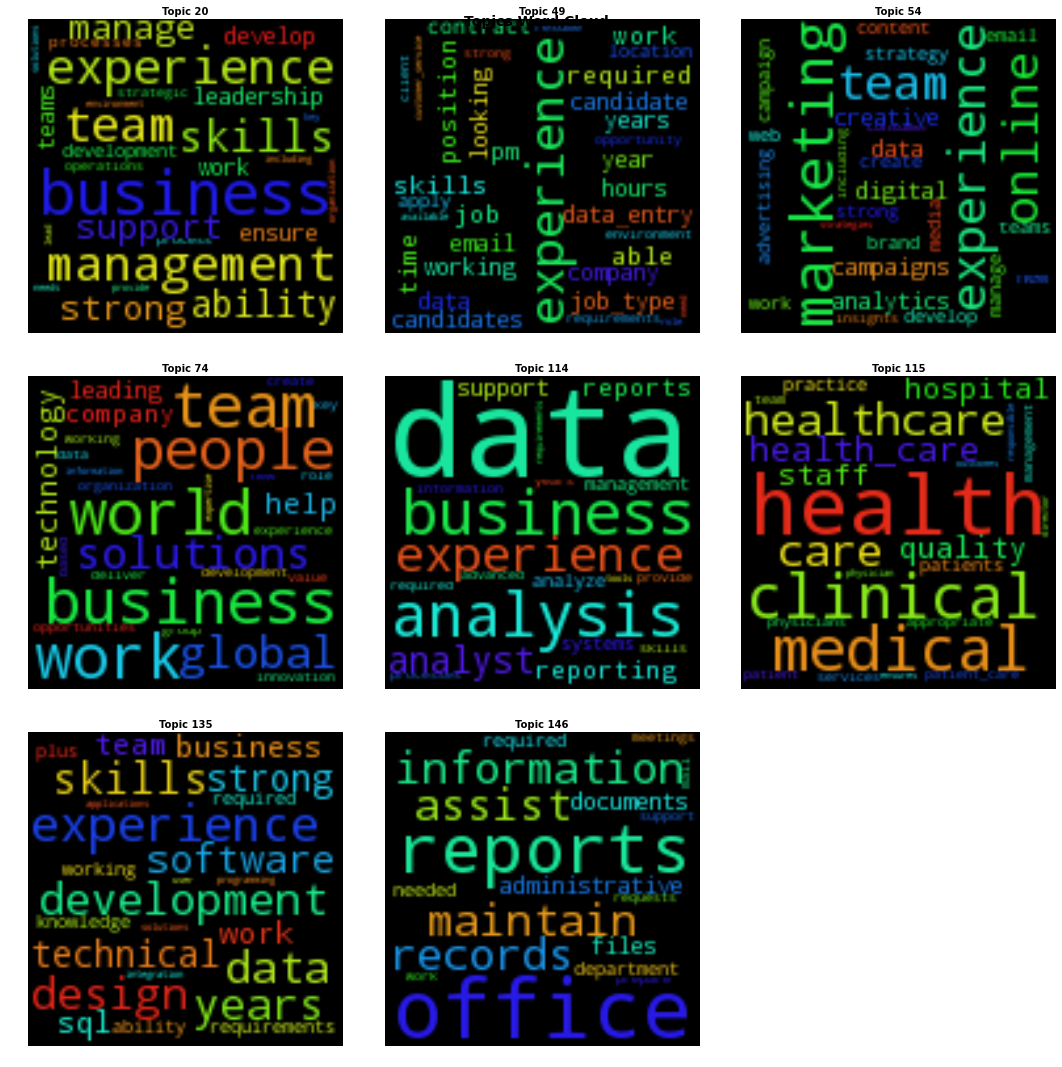

In [91]:
final_topics = open(os.path.join(MODEL_DIR, "train_jobs_topics.txt"), 'rb')
v = 0
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(left = 0.1, bottom=0.1, right=0.2, top=0.2)
wordcloud_topics = [20, 49, 146, 135, 74, 114, 54, 115]
number_of_subplots=len(wordcloud_topics)

for line in final_topics:
    line = line.strip('\n')
    curr_topic = line.split(':')[0]
    topic_scores = ''.join(line.split(':')[1:])

    if int(curr_topic) in wordcloud_topics:
        scores = [float(x.split("*")[0]) for x in topic_scores.split(" + ")]
        words = [x.split("*")[1] for x in topic_scores.split(" + ")]

        freqs = []
        for word, score in zip(words, scores):
            freqs.append((word, score))

        elements = WordCloud(width=120, height=120).fit_words(freqs)

        v += 1
        ax1 = fig.add_subplot(int(number_of_subplots/3)+1, 3, v)
        ax1.set_title("Topic {}".format(curr_topic), fontsize=10, fontweight='bold')
        ax1.imshow(elements)
        ax1.axis("off")
    else:
        continue

fig.suptitle("Topics Word Cloud", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()
final_topics.close()

In [85]:
import matplotlib
matplotlib.matplotlib_fname()

u'/usr/local/lib/python2.7/dist-packages/matplotlib/mpl-data/matplotlibrc'

In [86]:
import matplotlib.rcsetup as rcsetup
print(rcsetup.all_backends)

[u'GTK', u'GTKAgg', u'GTKCairo', u'MacOSX', u'Qt4Agg', u'Qt5Agg', u'TkAgg', u'WX', u'WXAgg', u'CocoaAgg', u'GTK3Cairo', u'GTK3Agg', u'WebAgg', u'nbAgg', u'agg', u'cairo', u'emf', u'gdk', u'pdf', u'pgf', u'ps', u'svg', u'template']


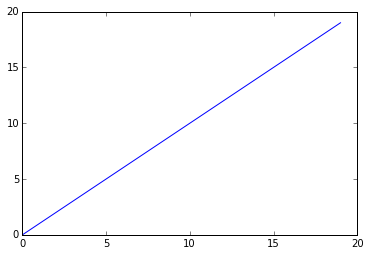

In [87]:
plt.plot(range(20),range(20))

---

In [70]:
!tail -3 ~/wrk/jobs/data/export_jobs_w_title.txt | awk -F'|' '{print $5}' > ~/wrk/jobs/data/test.txt
!tail -3 ~/wrk/jobs/data/export_jobs_w_title.txt | awk -F'|' '{print $1"|"$2"|"$3"|"$4}' > ~/wrk/jobs/data/test_labels.txt
!cat ~/wrk/jobs/data/test.txt
!cat ~/wrk/jobs/data/test_labels.txt

J.P. Morgan's Corporate & Investment Bank is a global leader across banking, markets and investor services. The world's most important corporations, governments and institutions entrust us with their business in more than 100 countries. With $18 trillion of assets under custody and $393 billion in deposits, the Corporate & Investment Bank provides strategic advice, raises capital, manages risk and extends liquidity in markets around the world. Market Risk Technology team is responsible for the technology platform and integration with JPM Morganâs risk systems to provide JP Morganâs risk managers with capability to assess impact of various market scenarios at a firm wide level. The team has a large book of work comprising of many strategic and tactical projects to enhance the system capabilities and continue with integration efforts with the firmâs risk systems along with the reduction of offline manual processes.   As a Senior Lead Architect, you will play important role in leadi

In [23]:
print os.path.join(DATA_DIR, "test.txt")

/home/rt/wrk/jobs/data/test.txt


In [24]:
for d in sentence_stream(open('/home/rt/wrk/jobs/data/test.txt')):
    print d

TypeError: coercing to Unicode: need string or buffer, file found

In [43]:
# compile sample documents into a list
dictionary = corpora.Dictionary.load(os.path.join(MODEL_DIR, "train.dict"))
dictionary.add_documents(sentence_stream(os.path.join(DATA_DIR, "test.txt")))
corpus = corpora.MmCorpus(os.path.join(MODEL_DIR, "train_jobs.mm"))

In [75]:
#test_dict = corpora.Dictionary(sentence_stream(os.path.join(DATA_DIR, "test.txt")))
test_bow = []
for sentence in sentence_stream(os.path.join(DATA_DIR, "test.txt")):
    test_bow.append(dictionary.doc2bow(sentence))

In [72]:
for sentence in sentence_stream(os.path.join(DATA_DIR, "test.txt")):
    print len(sentence)

417
483
342


In [76]:
test_topics = lda[test_bow]

In [99]:
for t in test_topics:
    [ x for x,y in sorted(t, key=lambda tup: tup[1], reverse = True)[:5] ]

[20, 69, 74, 102, 135]
[115, 57, 146, 61, 74]
[74, 54, 20, 101, 94]


In [115]:
final_topics = open(os.path.join(MODEL_DIR, "train_jobs_topics.txt"), 'rb')
topic_terms = {}

for line in final_topics:
    line = line.strip('\n')
    curr_topic = line.split(':')[0]
    topic_scores = ''.join(line.split(':')[1:])

    scores = [float(x.split("*")[0]) for x in topic_scores.split(" + ")]
    words = [x.split("*")[1] for x in topic_scores.split(" + ")]

    freqs = []
    for word, score in zip(words, scores):
        freqs.append((word, score))
    
    topic_terms[int(curr_topic)] = sorted(freqs, key=lambda tup: tup[1], reverse = True)[:50]

In [120]:
for t in test_topics:
    topn_topics = [ x for x,y in sorted(t, key=lambda tup: tup[1], reverse = True)[:5] ]
    terms = []
    for topic in topn_topics:
        print topic, topic_terms[topic]

20 [('business', 0.02), ('management', 0.02), ('experience', 0.014), ('team', 0.013), ('skills', 0.012)]
69 [('project', 0.088), ('requirements', 0.028), ('projects', 0.025), ('business', 0.019), ('work', 0.015)]
74 [('business', 0.014), ('work', 0.012), ('team', 0.009), ('world', 0.007), ('people', 0.007)]
102 [('experience', 0.036), ('systems', 0.032), ('database', 0.022), ('application', 0.022), ('management', 0.019)]
135 [('experience', 0.057), ('development', 0.02), ('data', 0.018), ('design', 0.017), ('skills', 0.016)]
115 [('health', 0.046), ('clinical', 0.038), ('medical', 0.036), ('healthcare', 0.036), ('care', 0.026)]
57 [('treatment', 0.031), ('patient', 0.021), ('dialysis', 0.017), ('patients', 0.015), ('appropriate', 0.014)]
146 [('office', 0.018), ('reports', 0.017), ('information', 0.015), ('maintain', 0.014), ('assist', 0.012)]
61 [('patient', 0.062), ('patients', 0.04), ('information', 0.024), ('medical', 0.017), ('required', 0.013)]
74 [('business', 0.014), ('work', 0

In [95]:
test_df = pd.read_csv(os.path.join(DATA_DIR, "test_labels.txt"), sep="|", names = ['id', 'title','company', 'url'], skiprows=0)
test_df[['title', 'company']]

,title,company
0,RFRM-2 Lead Architect,JPMorgan Chase - Asset Management
1,Ward Clerk,Fresenius Medical Care
2,Associate Director/Director – Commercial Analy...,Axtria


---

In [128]:
dictionary = corpora.Dictionary.load(os.path.join(MODEL_DIR, "train.dict"))
corpus = corpora.MmCorpus(os.path.join(MODEL_DIR, "train_jobs.mm"))

In [130]:
jobs_corpus = JobCorpus(os.path.join(DATA_DIR, "train.txt"))

In [131]:
print jobs_corpus

In [136]:
class MySentences(object):
    def __init__(self, fname):
        self.fname = fname
        
    def __iter__(self):
        for line in open(self.fname):
            yield line.split()

sentences = MySentences(os.path.join(DATA_DIR, "train.txt"))

In [143]:
class Word2VecSentences(object):
    def __init__(self, fname):
        self.fname = fname

        # blackist words to be removed from text
        # combines stopwords from nltk, gensim and stop_words package
        self.en_stopwords = set(
            stop_words.get_stop_words('en') +
            nltk.corpus.stopwords.words("english") +
            list(gensim.parsing.preprocessing.STOPWORDS)
        )

        # keep -, +, # in words
        self.punctuation = re.sub("[-+#.]", " ", punctuation)

        # make translation dictionary converting punctuations to white spaces
        self.translate_dict = maketrans(punctuation, ' '*len(punctuation))

        # replace patterns
        self.invalid_char = re.compile(r'[0-9]|\\~|\`|\@|\$|\%|\^|\& \
                |\*|\(|\)|\_|\=|\[|\]|\\|\<|\<|\>|\?|\/|\;|\\.')
        self.url_pattern = re.compile(r'(' +
              # Scheme (HTTP, HTTPS, FTP and SFTP):
              r'(?:(https?|s?ftp):\/\/)?' +
              # www:
              r'(?:www\.)?' + 
              r'(' +
              # Host and domain (including ccSLD):
              r'(?:(?:[A-Z0-9][A-Z0-9-]{0,61}[A-Z0-9]\.)+)' +
              # TLD:
              r'([A-Z]{2,6})' +
              # IP Address:
              r'|(?:\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3})' +
              r')' +
              # Port:
              r'(?::(\d{1,5}))?' +
              # Query path:
              r'(?:(\/\S+)*)' +
              r')', re.IGNORECASE)

    def cleanse_text(self, text):
        clean_text = text

        # remove urls from text
        clean_text = self.url_pattern.sub('', clean_text)
        
        # remove punctuations and other characters
        clean_text = translate(
            self.invalid_char.sub(' ', clean_text),
            self.translate_dict)

        return clean_text

    def split_words(self, document):
        """
        Break text into sentences and each sentence into a list of single words
        Ignore any token that falls into the stopwords set.
        """
        # use sentence tokenizer sent_tokenize from nltk package
        sentences = sent_tokenize(document.lower().decode('unicode_escape').encode('ascii', 'ignore'))
        
        for sentence in sentences:
            words = [word
                   for word in gensim.utils.tokenize(
                    self.cleanse_text(sentence)
                   )
                   if word not in self.en_stopwords]
            yield words

    def tokenize(self):
        """
        Break text (string) into a list of unicode tokens.
        The resulting tokens can be longer phrases (collocations) too,
        e.g. `new_york`, `real_estate` etc.
        """
        for document in open(self.fname):
            post = []
            for sentences in self.split_words(document):
                post.extend(list(sentences))
            yield post
            
    def __iter__(self):
        for sentence in self.tokenize():
            yield sentence

In [145]:
sentences = Word2VecSentences(os.path.join(DATA_DIR, "train.txt"))

In [146]:
word2vec = gensim.models.Word2Vec(sentences, size=100, window=5, min_count=5)

In [165]:
%%time
bigram_transformer = gensim.models.Phrases(sentences)
trigram_transformer = gensim.models.Phrases(bigram_transformer[sentences])
fourgram_transformer = gensim.models.Phrases(trigram_transformer[sentences])

CPU times: user 3min 19s, sys: 16.3 s, total: 3min 35s
Wall time: 3min 41s


In [166]:
%%time
word2vec = gensim.models.Word2Vec(fourgram_transformer[sentences], size=100, window=5, min_count=5)
word2vec.save(os.path.join(MODEL_DIR, "train_model.w2v"))

CPU times: user 2min 41s, sys: 13.4 s, total: 2min 54s
Wall time: 2min 57s


In [167]:
word2vec.most_similar(['machine_learning'])

[(u'algorithms', 0.8583469390869141),
 (u'predictive_modeling', 0.8387719988822937),
 (u'data_mining', 0.8214297294616699),
 (u'predictive_analytics', 0.7932194471359253),
 (u'nlp', 0.7907448410987854),
 (u'data_visualization', 0.7896145582199097),
 (u'statistical_modeling', 0.78826504945755),
 (u'data_modeling', 0.7874375581741333),
 (u'visualization', 0.7810636162757874),
 (u'modeling', 0.7794164419174194)]

In [180]:
word2vec.most_similar('data_analyst')

[(u'business_analyst', 0.7962606549263),
 (u'data_scientist', 0.7712973952293396),
 (u'month_contract', 0.7351280450820923),
 (u'financial_analyst', 0.727946937084198),
 (u'sr', 0.7208335399627686),
 (u'software_developer', 0.7153319716453552),
 (u'net_developer', 0.709591805934906),
 (u'immediate_need', 0.7073204517364502),
 (u'java_developer', 0.704949676990509),
 (u'direct_client', 0.6995848417282104)]

---

download tools and technologies from https://www.onetcenter.org/dl_files/database/db_20_2_text/Tools%20and%20Technology.txt

Analytical or scientific software
Data base user interface and query software
Enterprise resource planning ERP software
Project management software
Development environment software
Information retrieval or search software
Web page creation and editing software
Operating system software
Program testing software
Data base management system software
Object or component oriented development software
Web platform development software
Data base reporting software
Desktop publishing software
Enterprise application integration software
Data mining software
Metadata management software
Business intelligence and data analysis software
Configuration management software
Object oriented data base management software
Clustering software
Enterprise system management software
File versioning software

In [ ]:
!grep -f r-tech.txt tech_u.txt > tech_r.txt
!awk -F'@#!' 'BEGIN{OFS="\t"} {if (NF == 1) {parent = $1} else {print $NF, parent}}' ACMTaxonomyFlat.txt >> tech_r.txt

In [26]:
fname = os.path.join(DATA_DIR, "small_train.txt")

In [9]:
# blackist words to be removed from text
# combines stopwords from nltk, gensim and stop_words package
en_stopwords = set(
    stop_words.get_stop_words('en') +
    nltk.corpus.stopwords.words("english") +
    list(gensim.parsing.preprocessing.STOPWORDS)
)

# keep -, +, # in words
punctuation = re.sub("[-+#.]", " ", punctuation)

# make translation dictionary converting punctuations to white spaces
translate_dict = maketrans(punctuation, ' '*len(punctuation))

# replace patterns
invalid_char = re.compile(r'[0-9]|\\~|\`|\@|\$|\%|\^|\& \
        |\*|\(|\)|\_|\=|\[|\]|\\|\<|\<|\>|\?|\/|\;|\\.')
url_pattern = re.compile(r'(' +
      # Scheme (HTTP, HTTPS, FTP and SFTP):
      r'(?:(https?|s?ftp):\/\/)?' +
      # www:
      r'(?:www\.)?' + 
      r'(' +
      # Host and domain (including ccSLD):
      r'(?:(?:[A-Z0-9][A-Z0-9-]{0,61}[A-Z0-9]\.)+)' +
      # TLD:
      r'([A-Z]{2,6})' +
      # IP Address:
      r'|(?:\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3})' +
      r')' +
      # Port:
      r'(?::(\d{1,5}))?' +
      # Query path:
      r'(?:(\/\S+)*)' +
      r')', re.IGNORECASE)

In [26]:
    def cleanse_text(text):
        clean_text = text

        # remove urls from text
        clean_text = url_pattern.sub('', clean_text)
        
        # remove punctuations and other characters
        clean_text = translate(
            invalid_char.sub(' ', clean_text),
            translate_dict)

        return clean_text

In [27]:
    def split_words(document):
        """
        Break text into sentences and each sentence into a list of single words
        Ignore any token that falls into the stopwords set.
        """
        # use sentence tokenizer sent_tokenize from nltk package
        sentences = sent_tokenize(document.lower().decode('unicode_escape').encode('ascii', 'ignore'))
        
        for sentence in sentences:
            words = [word
                   for word in gensim.utils.tokenize(
                    cleanse_text(sentence)
                   )
                   if word not in en_stopwords]
            yield words

In [58]:
    def sentence_stream(f_name):
        for document in open(f_name):
            post = []
            for sentences in split_words(document):
                post.extend(list(sentences))
            yield post

In [96]:
documents = (sentence_stream(fname))

In [ ]:
for document in list(documents):
    print document